In [1]:
!git clone https://github.com/mtrautner/BoundFNO.git

Cloning into 'BoundFNO'...
remote: Enumerating objects: 640, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 640 (delta 48), reused 62 (delta 20), pack-reused 543 (from 1)
Receiving objects: 100% (640/640), 953.02 MiB | 29.50 MiB/s, done.
Resolving deltas: 100% (326/326), done.
Updating files: 100% (199/199), done.


In [4]:
%cd /content/BoundFNO

/content/BoundFNO


In [5]:
%ls

AdaptiveSubsampling.ipynb  Figures/                train_fno.py
analysis/                  gen_GRF.py              train_fno_subsampling.py
boundfno.yml               jobScripts/             train_grad_model.py
check_regularity.py        models/                 training_playground.ipynb
data/                      train_FNM_f2v_model.py  util/


In [6]:
pip install pyyaml torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.8 MB/s eta 0:00:00


In [7]:
from analysis.eval_model_helpers import *
from util.utilities_module import *
from gen_GRF import *
import torch
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pdb
import sys
import os
sys.path.append(os.path.join('..'))
from models.shared import SpectralConv2d, projector2d, get_grid2d, _get_act, MLP

def undo_padding(layer,padding):
    """
    padding         (int or float): (1.0/padding) is fraction of domain to zero pad (non-periodic)
    layers         (torch tensor): dims (batch, channels, x, y) where x and y are padded
    grid_size* (1+ 1/padding) = x (or y) where grid_size is the size of the grid in the original domain (before padding)
    assumes square grid
    """
    # num_pad = layer.shape[-1]//padding
    orig_dim = int(layer.shape[-1]//(1+1/padding))
    num_pad = layer.shape[-1] - orig_dim
    layer_out = layer[...,:-num_pad,:-num_pad]
    return layer_out

class FNO2d(nn.Module):
    """
    Fourier Neural Operator for mapping functions to functions
    """
    def __init__(self,
                 modes1=12,
                 modes2=12,
                 width=32,
                 s_outputspace=(2048, 2048),
                 width_final=128,
                 padding=8,
                 d_in=1,
                 d_out=1,
                 act='gelu',
                 n_layers=4,
                 get_grid=False,
                 periodic_grid = True
                 ):
        """
        modes1, modes2  (int): Fourier mode truncation levels
        width           (int): constant dimension of channel space
        s_outputspace   (list or tuple, length 2): desired spatial resolution (s,s) in output space
        width_final     (int): width of the final projection layer
        padding         (int or float): (1.0/padding) is fraction of domain to zero pad (non-periodic)
        d_in            (int): number of input channels (NOT including grid input features)
        d_out           (int): number of output channels (co-domain dimension of output space functions)
        act             (str): Activation function = tanh, relu, gelu, elu, or leakyrelu
        n_layers        (int): Number of Fourier Layers, by default 4
        get_grid        (bool): Whether or not append grid coordinate as a feature for the input
        """
        super(FNO2d, self).__init__()

        self.d_physical = 2
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.width_final = width_final
        self.padding = padding
        self.d_in = d_in
        self.d_out = d_out
        self.act = _get_act(act)
        self.n_layers = n_layers
        self.get_grid = get_grid
        self.periodic_grid = periodic_grid
        if self.n_layers is None:
            self.n_layers = 4

        self.set_outputspace_resolution((2048,2048))

        self.fc0 = nn.Linear((self.d_in + (1+1*self.periodic_grid)*self.d_physical if get_grid else self.d_in), self.width)
        self.speconvs = nn.ModuleList([
            SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
                for _ in range(self.n_layers)]
            )

        self.ws = nn.ModuleList([
            nn.Conv2d(self.width, self.width, 1)
                for _ in range(self.n_layers)]
            )

        self.mlp0 = MLP(self.width, self.width_final, self.d_out, act)

    def forward(self, x, invasive = False,USE_CUDA = False):
        """
        Input shape (of x):     (batch, channels_in, nx_in, ny_in)
        Output shape:           (batch, channels_out, nx_out, ny_out)

        The input resolution is determined by x.shape[-2:]
        The output resolution is determined by self.s_outputspace
        """
        # Lifting layer

        x_res = x.shape[-2:]
        x = x.permute(0, 2, 3, 1)
        if self.get_grid:
            x = torch.cat((x, get_grid2d(x.shape, x.device,periodic = self.periodic_grid)), dim=-1)   # grid ``features''

        if USE_CUDA:
            x = x.cuda()

        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        # Collect layer outputs
        if invasive:
            layer_outputs = []

        # # Map from input domain into the torus
        x_res_padded_space = (x_res[-1] + x_res[-1]//self.padding, x_res[-2] + x_res[-2]//self.padding)

        # Fourier integral operator layers on the torus
        for idx_layer, (speconv, w) in enumerate(zip(self.speconvs, self.ws)):
            if idx_layer != self.n_layers - 1:
                if invasive:
                    x_high_res =  speconv(x, s=self.s_outputspace) + w(projector2d(x, s=self.s_outputspace))
                    x_high_res = self.act(x_high_res)

                x = speconv(x, s= x_res_padded_space) + w(projector2d(x, s= x_res_padded_space))
                x = self.act(x)
                if invasive:
                    x_high_res = x_high_res[..., :-self.num_pad_outputspace[-2], :-self.num_pad_outputspace[-1]] # removes padding
                    layer_outputs.append(x_high_res.cpu())
            else:
                # Change resolution in function space consistent way
                x = speconv(x, s=self.s_outputspace) + w(projector2d(x, s=self.s_outputspace))

        # Map from the torus into the output domain
        if self.s_outputspace is not None:
            x = x[..., :-self.num_pad_outputspace[-2], :-self.num_pad_outputspace[-1]]
        else:
            x = x[..., :-(x_res[-2]//self.padding), :-(x_res[-1]//self.padding)]

        # Final projection layer
        x = x.permute(0, 2, 3, 1)
        x = self.mlp0(x)

        if invasive:
            x = x.permute(0, 3, 1, 2)
            return layer_outputs
        if not invasive:
            return x.permute(0, 3, 1, 2)

    def set_outputspace_resolution(self, s=None):
        """
        Helper to set desired output space resolution of the model at any time
        """
        if s is None:
            self.s_outputspace = None
            self.num_pad_outputspace = None
        else:
            self.s_outputspace = tuple([r + r//self.padding for r in list(s)])
            self.num_pad_outputspace = tuple([r//self.padding for r in list(s)])

In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import sys
sys.path.append(os.path.join('..'))

In [85]:
class MLP(nn.Module):
    """
    MLP with two inputs. Each input passes through a separate linear layer,
    then their outputs are multiplied before passing through the final layer.
    """
    def __init__(self, channels_in, channels_hid, channels_out):
        super(MLP, self).__init__()

        # Separate linear layers for each input
        self.fc1_value = nn.Linear(channels_in, channels_hid)
        self.fc1_gate = nn.Linear(channels_in, channels_hid)

        # Final layer
        self.fc2 = nn.Linear(channels_hid, channels_out)

    def forward(self, value_x, gate_x):
        """
        Inputs:
        - value_x: Tensor of shape (..., channels_in)
        - gate_x: Tensor of shape (..., channels_in)

        Output:
        - Tensor of shape (..., channels_out)
        """
        value_out = self.fc1_value(value_x)
        gate_out = self.fc1_gate(gate_x)

        # Multiply the two outputs element-wise
        x = value_out * gate_out
        # Final linear layer
        x = self.fc2(x)

        return x

In [86]:
from models.shared import SpectralConv2d, projector2d, get_grid2d, _get_act

def undo_padding(layer, padding):
    orig_dim = int(layer.shape[-1] // (1 + 1 / padding))
    num_pad = layer.shape[-1] - orig_dim
    return layer[..., :-num_pad, :-num_pad]

class GatedFNO2d(nn.Module):
    def __init__(self, modes1=12, modes2=12, width=32, s_outputspace=None, width_final=128,
                 padding=8, d_in=1, d_out=1, act='gelu', n_layers=4, get_grid=False, periodic_grid=True):
        super(GatedFNO2d, self).__init__()

        self.d_physical = 2
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.width_final = width_final
        self.padding = padding
        self.d_in = d_in
        self.d_out = d_out
        self.act = _get_act(act)
        self.n_layers = n_layers if n_layers is not None else 4
        self.get_grid = get_grid
        self.periodic_grid = periodic_grid

        self.set_outputspace_resolution(s_outputspace)

        self.fc0 = nn.Linear((self.d_in + (1 + 1 * self.periodic_grid) * self.d_physical if get_grid else self.d_in), self.width)

        self.speconvs = nn.ModuleList([SpectralConv2d(self.width, self.width, self.modes1, self.modes2) for _ in range(self.n_layers)])
        self.ws = nn.ModuleList([nn.Conv2d(self.width, self.width, 1) for _ in range(self.n_layers)])

        # Gating network
        self.gate_fc0 = nn.Linear((self.d_in + (1 + 1 * self.periodic_grid) * self.d_physical if get_grid else self.d_in), self.width)
        self.gate_speconvs = nn.ModuleList([SpectralConv2d(self.width, self.width, self.modes1, self.modes2) for _ in range(self.n_layers)])
        self.gate_ws = nn.ModuleList([nn.Conv2d(self.width, self.width, 1) for _ in range(self.n_layers)])

        self.mlp0 = MLP(self.width, self.width_final, self.d_out)

    def forward(self, x, invasive = False,USE_CUDA = False):
        """
        Input shape (of x):     (batch, channels_in, nx_in, ny_in)
        Output shape:           (batch, channels_out, nx_out, ny_out)

        The input resolution is determined by x.shape[-2:]
        The output resolution is determined by self.s_outputspace
        """
        # Lifting layer

        x_res = x.shape[-2:]
        x = x.permute(0, 2, 3, 1)
        if self.get_grid:
            x = torch.cat((x, get_grid2d(x.shape, x.device,periodic = self.periodic_grid)), dim=-1)   # grid ``features''

        if USE_CUDA:
            x = x.cuda()

        value_x = torch.ones_like(x)
        value_x = self.fc0(value_x)
        value_x = value_x.permute(0, 3, 1, 2)

        gate_x = self.fc0(x)
        gate_x = gate_x.permute(0, 3, 1, 2)

        # Collect layer outputs
        if invasive:
            layer_outputs = []

        # # Map from input domain into the torus
        x_res_padded_space = (x_res[-1] + x_res[-1]//self.padding, x_res[-2] + x_res[-2]//self.padding)

        # Fourier integral operator layers on the torus
        for idx_layer, (gate_speconv, gate_w, speconv, w) in enumerate(zip(self.gate_speconvs, self.gate_ws, self.speconvs, self.ws)):
            if idx_layer != self.n_layers - 1:
                if invasive:
                    value_x_high_res =  speconv(value_x, s=self.s_outputspace) + w(projector2d(value_x, s=self.s_outputspace))
                    gate_x_high_res = gate_speconv(gate_x, s=self.s_outputspace) + gate_w(projector2d(gate_x, s=self.s_outputspace))
                    value_x_high_res = value_x_high_res * gate_x_high_res

                value_x = speconv(value_x, s= x_res_padded_space) + w(projector2d(value_x, s= x_res_padded_space))
                gate_x = gate_speconv(gate_x, s= x_res_padded_space) + gate_w(projector2d(gate_x, s= x_res_padded_space))
                value_x = value_x * gate_x
                if invasive:
                    value_x_high_res = value_x_high_res[..., :-self.num_pad_outputspace[-2], :-self.num_pad_outputspace[-1]] # removes padding
                    layer_outputs.append(value_x_high_res.cpu())
            else:
                # Change resolution in function space consistent way
                value_x = speconv(value_x, s= x_res_padded_space) + w(projector2d(value_x, s= x_res_padded_space))
                gate_x = gate_speconv(gate_x, s= x_res_padded_space) + gate_w(projector2d(gate_x, s= x_res_padded_space))
                value_x = value_x * gate_x

        # Map from the torus into the output domain
        if self.s_outputspace is not None:
            value_x = value_x[..., :-self.num_pad_outputspace[-2], :-self.num_pad_outputspace[-1]]
            gate_x = gate_x[..., :-self.num_pad_outputspace[-2], :-self.num_pad_outputspace[-1]]
        else:
            gate_x = gate_x[..., :-(x_res[-2]//self.padding), :-(x_res[-1]//self.padding)]
            value_x = value_x[..., :-(x_res[-2]//self.padding), :-(x_res[-1]//self.padding)]

        # Final projection layer
        value_x = value_x.permute(0, 2, 3, 1)
        gate_x = gate_x.permute(0, 2, 3, 1)
        x = self.mlp0(value_x, gate_x)

        if invasive:
            x = x.permute(0, 3, 1, 2)
            return layer_outputs
        if not invasive:
            return x.permute(0, 3, 1, 2)

    def set_outputspace_resolution(self, s=None):
        if s is None:
            self.s_outputspace = None
            self.num_pad_outputspace = None
        else:
            self.s_outputspace = tuple([r + r // self.padding for r in list(s)])
            self.num_pad_outputspace = tuple([r // self.padding for r in list(s)])

In [9]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = ['Dejavu Serif'] #'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'custom'
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00',
                    '#000000']
matplotlib.rcParams['mathtext.rm'] = 'stix'
matplotlib.rcParams['mathtext.it'] = 'stix'
matplotlib.rcParams['mathtext.bf'] = 'stix'


matplotlib.rcParams["axes.formatter.limits"] = (-99, 99) #makes scientific notation threshold high
plt.rcParams['font.family'] = 'Dejavu Serif'
plt.rcParams['font.serif'] = ['Times'] #['Times New Roman']  # 'DejaVu Serif' 'serif' 'Times

tickfontsize = 25
fontsize = 25
linewidth = 4
markersize = 15

SMALL_SIZE = tickfontsize
MEDIUM_SIZE = tickfontsize
BIGGER_SIZE = fontsize

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

shapes = ['o','s','^','D','*', 'x', 'P', 'h', 'v', '<', '>', 'X', 'd', 'p', '|', '_', '.', ',']

In [10]:
# Generate data (GRF inputs)
s_vals = [ 1, 2]

In [ ]:
/content/BoundFNO/data/GRF_s1/GRF_size_1024_0.pkl

In [11]:
# process input arguments
sizes = [64, 128,256, 512, 1024, 2048]
sample_count = 5
for s in s_vals:
    for n in range(sample_count):
        gfields = gaussian_random_field(s, sizes = sizes)
        # save GRF
        for i, size in enumerate(sizes):
            Z = gfields[i]
            pkl.dump(Z, open("data/GRF_s"+  str(s) + "/GRF_size_" + str(size) + "_" + str(n) + ".pkl", "wb"))

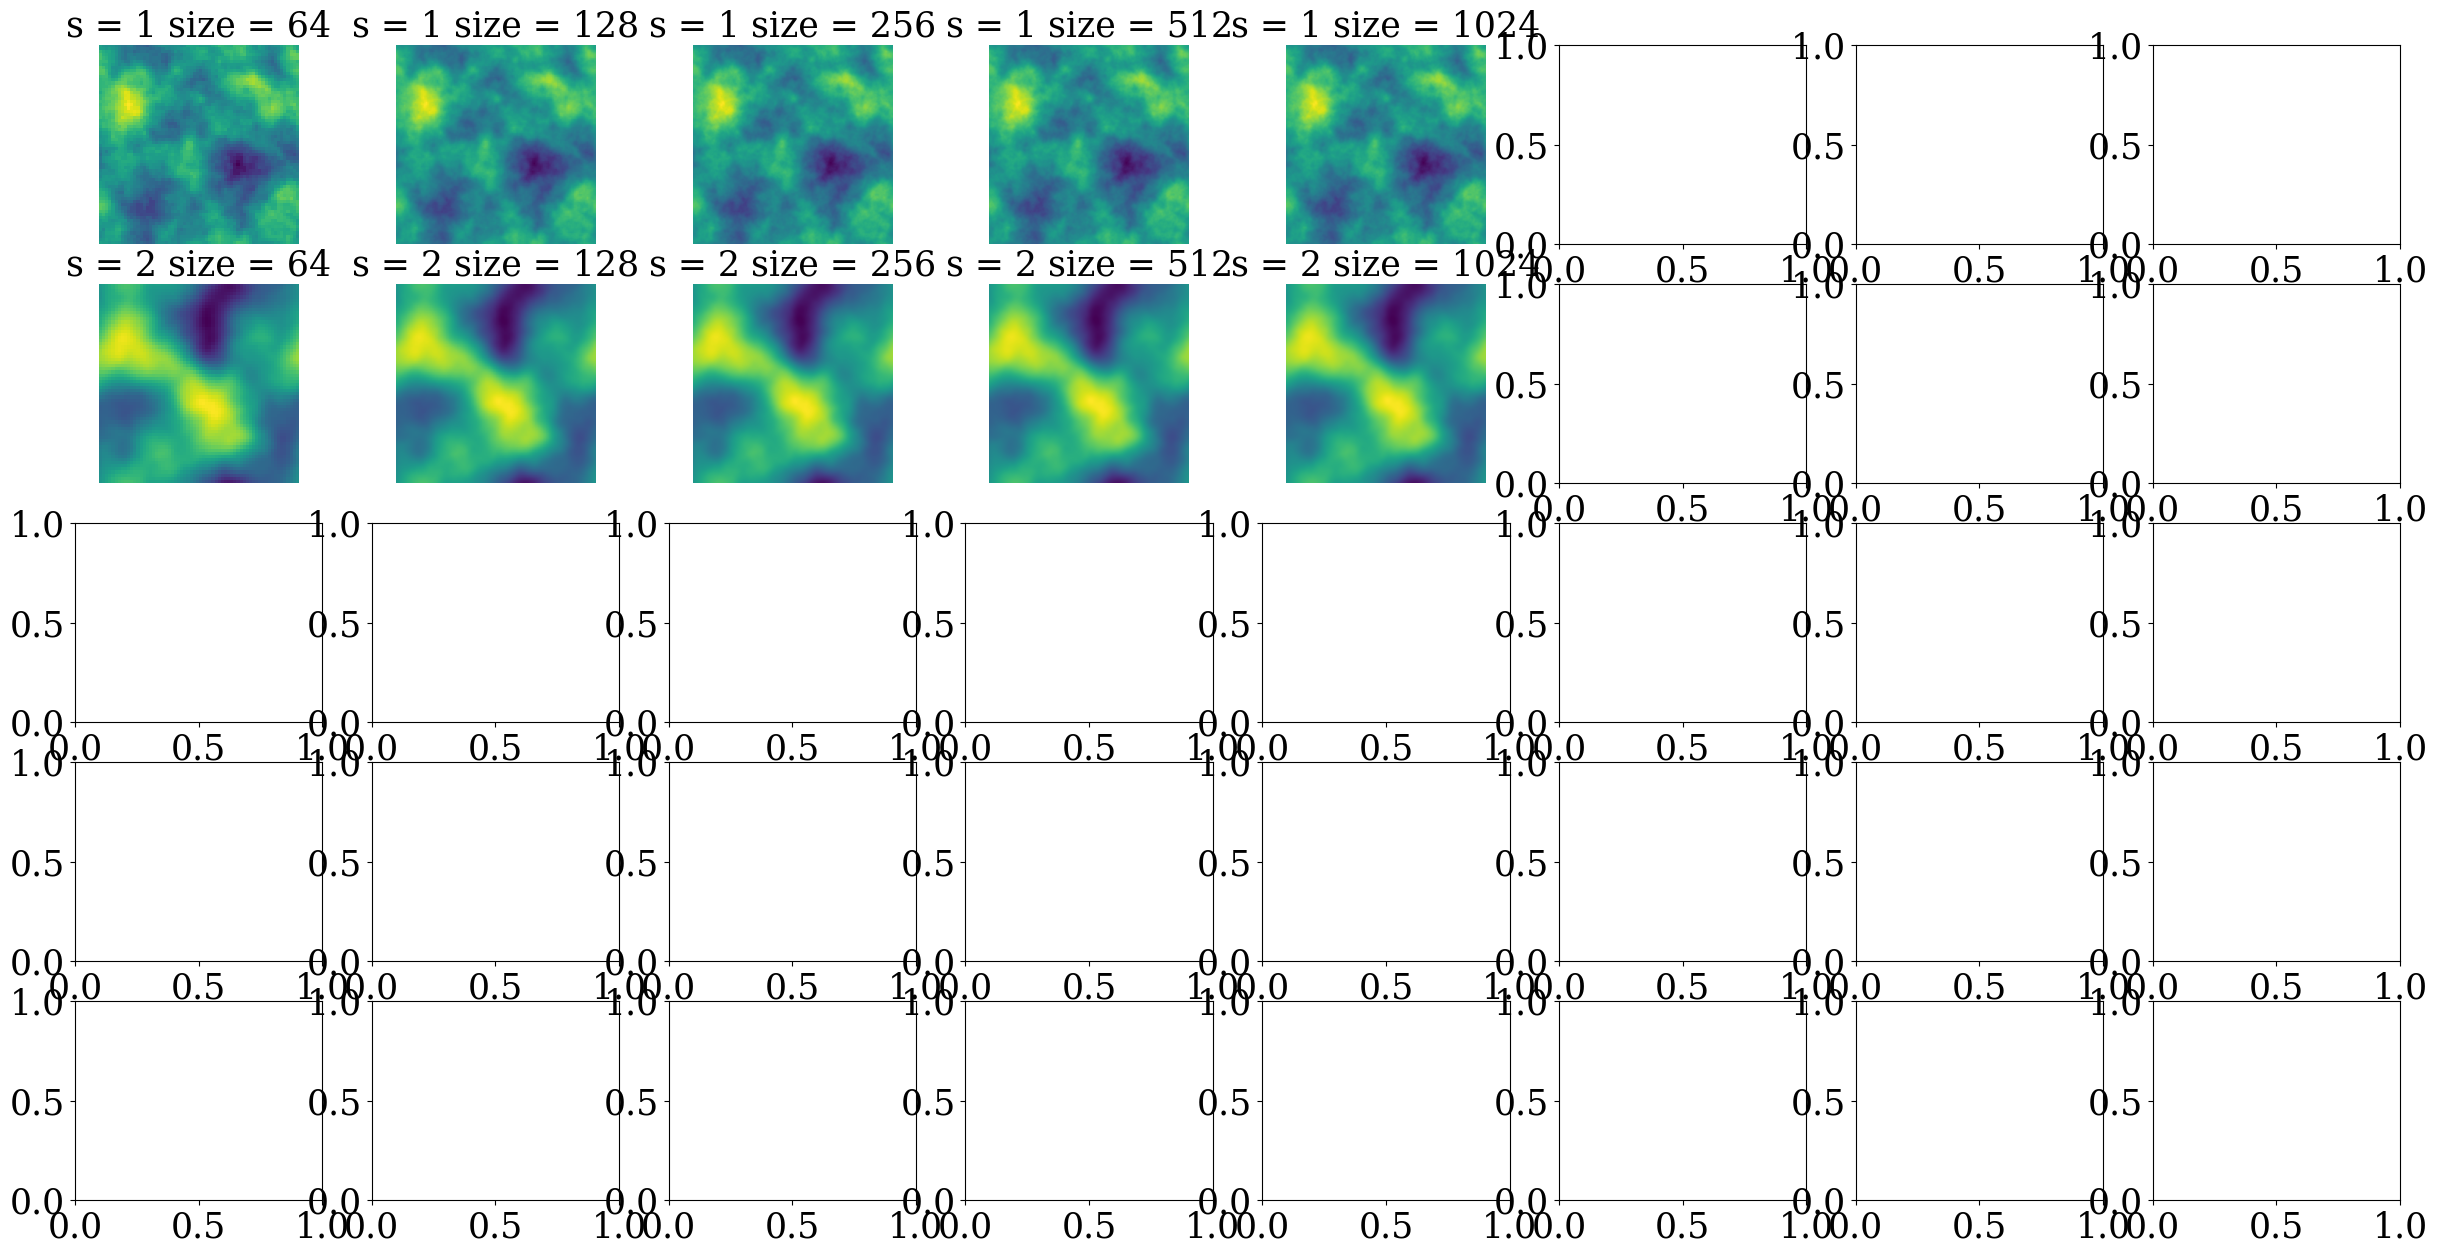

In [11]:
# Plot GRFs
fig, ax = plt.subplots(5, 8, figsize=(30, 15))
for i, s in enumerate(s_vals):
    for j, size in enumerate(sizes[:-1]):
        Z = pkl.load(open("/content/BoundFNO/data/GRF_s"+  str(s) + "/GRF_size_" + str(size) + "_0.pkl", "rb"))
        ax[i, j].imshow(Z, cmap='viridis')
        ax[i, j].set_title("s = " + str(s) + " size = " + str(size))
        ax[i, j].axis('off')

In [12]:
os.makedirs('models/untrained_models/', exist_ok=True)
os.makedirs('Figures/figure-data/', exist_ok=True)

In [13]:
def generate_initial_model(modes, width, device, get_grid=False,n_layers = 4,act = 'gelu',periodic_grid = True):
    '''
    Generates a random initial model for the FNO model
    '''
    model = FNO2d(modes1 = modes, modes2 = modes, width = width, s_outputspace=(2048, 2048), get_grid = get_grid, act = act, n_layers = n_layers, periodic_grid=periodic_grid).to(device)
    return model

def save_model_info(K,width,device,get_grid,n_layers,model_name, act = 'gelu',initialization = 'default',periodic = 'False'):
    model_info = 'models/untrained_models/' + model_name + '_info.yaml'
    with open(model_info, 'w') as file:
        yaml.dump({'K': K, 'width': width, 'device': device, 'get_grid': get_grid, 'n_layers': n_layers,'act': act,'initialization': initialization,'periodic_grid': periodic}, file)

In [14]:
K = 12
width = 32
device = 'cpu'
get_grid = False
n_layers = 4
SEED = 1989

In [15]:
torch.manual_seed(SEED)
model = generate_initial_model(K, width, device, get_grid,n_layers = n_layers)
model_name = 'default_model'
save_model_info(K,width,device,get_grid,n_layers,model_name,act = 'gelu',initialization = 'default')
torch.save(model.state_dict(), 'models/untrained_models/' + model_name + '.pt')

In [ ]:
input_data = torch.load('data/smooth_training_data/A_to_chi1_tiny_256_input_data_256.pt')
output_data = torch.load('data/smooth_training_data/A_to_chi1_tiny_256_output_data_256.pt')

FileNotFoundError: [Errno 2] No such file or directory: 'data/smooth_training_data/A_to_chi1_tiny_256_input_data_256.pt'

In [16]:
from analysis.eval_model_helpers import *
from util.utilities_module import *
from gen_GRF import *
import torch
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import yaml

In [17]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = ['Dejavu Serif'] #'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'custom'
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00',
                    '#000000']
matplotlib.rcParams['mathtext.rm'] = 'stix'
matplotlib.rcParams['mathtext.it'] = 'stix'
matplotlib.rcParams['mathtext.bf'] = 'stix'


matplotlib.rcParams["axes.formatter.limits"] = (-99, 99) #makes scientific notation threshold high
plt.rcParams['font.family'] = 'Dejavu Serif'
plt.rcParams['font.serif'] = ['Times'] #['Times New Roman']  # 'DejaVu Serif' 'serif' 'Times

tickfontsize = 33
fontsize = 33
linewidth = 4
markersize = 15

SMALL_SIZE = tickfontsize
MEDIUM_SIZE = tickfontsize
BIGGER_SIZE = fontsize

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

shapes = ['o','s','^','D','*', 'x', 'P', 'h', 'v', '<', '>', 'X', 'd', 'p', '|', '_', '.', ',']

In [18]:
s_vals = [1,2]
sizes = [ 64,128,256,512, 2048]
plot_sizes = sizes[:-1]

In [19]:
def get_err_norms(s,model_name, sizes):
    # model_name = 'initial_model_K_12_0_all1'
    model_info_path = 'models/untrained_models/' + model_name + '_info.yaml'
    model_path = 'models/untrained_models/' + model_name + '.pt'

    samp_count_model = 1
    samp_count_input = 5
    true_size = sizes[-1]

    # Load model
    model = FNO2d(modes1 = 12, modes2 = 12, width = 32,s_outputspace=(2048, 2048), get_grid = False, act = 'gelu', n_layers = 6, periodic_grid=True).to(device)
    n_layers = 4

    true_norms = torch.zeros(n_layers, samp_count_input)
    all_err = torch.zeros(len(sizes)-1,n_layers, samp_count_model, samp_count_input)

    for input_i in range(samp_count_input):
        true_input_path = 'data/GRF_s' + str(s) +'/GRF_size_' + str(true_size) + '_' + str(input_i)+ '.pkl'
        input_true = load_data(true_input_path)
        input_true = input_true.unsqueeze(0).unsqueeze(0)
        layers_true = get_layer_output(model,input_true)

        for size_i, size in enumerate(sizes[:-1]):
            disc_input_path = 'data/GRF_s' +str(s) + f'/GRF_size_{size}_'+ str(input_i)+'.pkl'
            input_disc = load_data(disc_input_path)
            input_disc = input_disc.unsqueeze(0).unsqueeze(0)
            layers_disc = get_layer_output(model,input_disc)
            for layer in range(n_layers):
                err = torch.norm(layers_disc[layer] - layers_true[layer])
                all_err[size_i,layer, 0, input_i] = err

                true_norms[layer, input_i] = torch.norm(layers_true[layer])

    all_err = all_err.detach().numpy()
    true_norms = true_norms.detach().numpy()
    all_err = all_err.reshape(len(sizes)-1,n_layers,samp_count_model*samp_count_input)

    return all_err, true_norms

In [20]:
def evaluate_model(model_name,s_vals,sizes):
    all_err_s = []
    true_norms_s = []
    for s in s_vals:
        all_err, true_norms = get_err_norms(s,model_name,sizes=sizes)
        all_err_s.append(all_err)
        true_norms_s.append(true_norms)

    true_norms_s = np.array(true_norms_s)
    all_err_s = np.array(all_err_s)
    return all_err_s, true_norms_s

In [21]:
def normalize_err(all_err_s,true_norms_s):
    # Normalize all_err_s by true_norms_s
    n_layers = true_norms_s.shape[1]
    all_err_s = np.array(all_err_s)
    n_samples = all_err_s.shape[-1]
    all_err_s_norm = np.zeros((len(s_vals),len(plot_sizes),n_layers,n_samples))
    for i in range(len(s_vals)):
        for j in range(n_layers):
            all_err_s_norm[i,:,j,:] = all_err_s[i,:,j,:] / true_norms_s[i,j,0]
    return all_err_s_norm

In [22]:
def plot_err_vs_N(all_err_s_norm,plot_sizes,plot_name):
    fix, ax = plt.subplots(1,4, figsize=(40, 10))

    for i, s in enumerate(s_vals):
        all_err = all_err_s_norm[i]

        all_err_mean = np.mean(all_err, axis = -1)
        all_err_std = 2*np.std(all_err, axis = -1)

        slopes = []

        for layer in range(all_err.shape[1]):
            ax[i].plot(plot_sizes,all_err_mean[:,layer],label = f'Layer {layer+1}',color = CB_color_cycle[layer],marker = shapes[layer],linewidth = linewidth,markersize = markersize)
            ax[i].errorbar(plot_sizes, all_err_mean[:,layer], yerr=all_err_std[:,layer],color = CB_color_cycle[layer])
            ax[i].fill_between(plot_sizes, all_err_mean[:,layer] - all_err_std[:,layer], all_err_mean[:,layer] + all_err_std[:,layer], alpha=0.2, color = CB_color_cycle[layer])

            p = np.polyfit(np.log(plot_sizes), np.log(all_err_mean[:,layer]), 1)
            slopes.append(p[0])

        ax[i].set_title('s = ' + str(s) + f',    Average Slope = {np.mean(slopes):.2f}')
        # logscale
        ax[i].set_yscale('log')
        # set y range
        ax[i].set_ylim([np.min(all_err_s_norm)/2, np.max(all_err_s_norm)*2])
        ax[i].set_xscale('log')
        ax[i].set_xlabel('N')
        ax[i].set_xticks([])
        ax[i].xaxis.set_minor_locator(plt.NullLocator())

        # no scientific notation x labels

        ax[i].set_xticks(plot_sizes, plot_sizes)
    ax[0].set_ylabel('Relative Error')
    ax[0].legend()
    ax[3].legend()
    # save figure
    plt.savefig('Figures/' + plot_name + '.pdf')

In [23]:
def save_data(all_err_s, true_norms_s, all_err_s_norm, model_name):
    save_path = 'Figures/figure-data/' + model_name + '_data.yaml'
    data = {'all_err_s': all_err_s, 'true_norms_s': true_norms_s, 'all_err_s_norm': all_err_s_norm}
    with open(save_path, 'w') as file:
        yaml.dump(data, file)

In [24]:
model_name = 'default_model'
all_err_s, true_norms_s = evaluate_model(model_name,s_vals, sizes)
print(all_err_s.shape)
all_err_s_norm = normalize_err(all_err_s,true_norms_s)
save_data(all_err_s, true_norms_s, all_err_s_norm, model_name)

KeyboardInterrupt: 

In [ ]:
save_data(all_err_s, true_norms_s, all_err_s_norm, model_name)

<ipython-input-36-10e379ec9485>:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[3].legend()


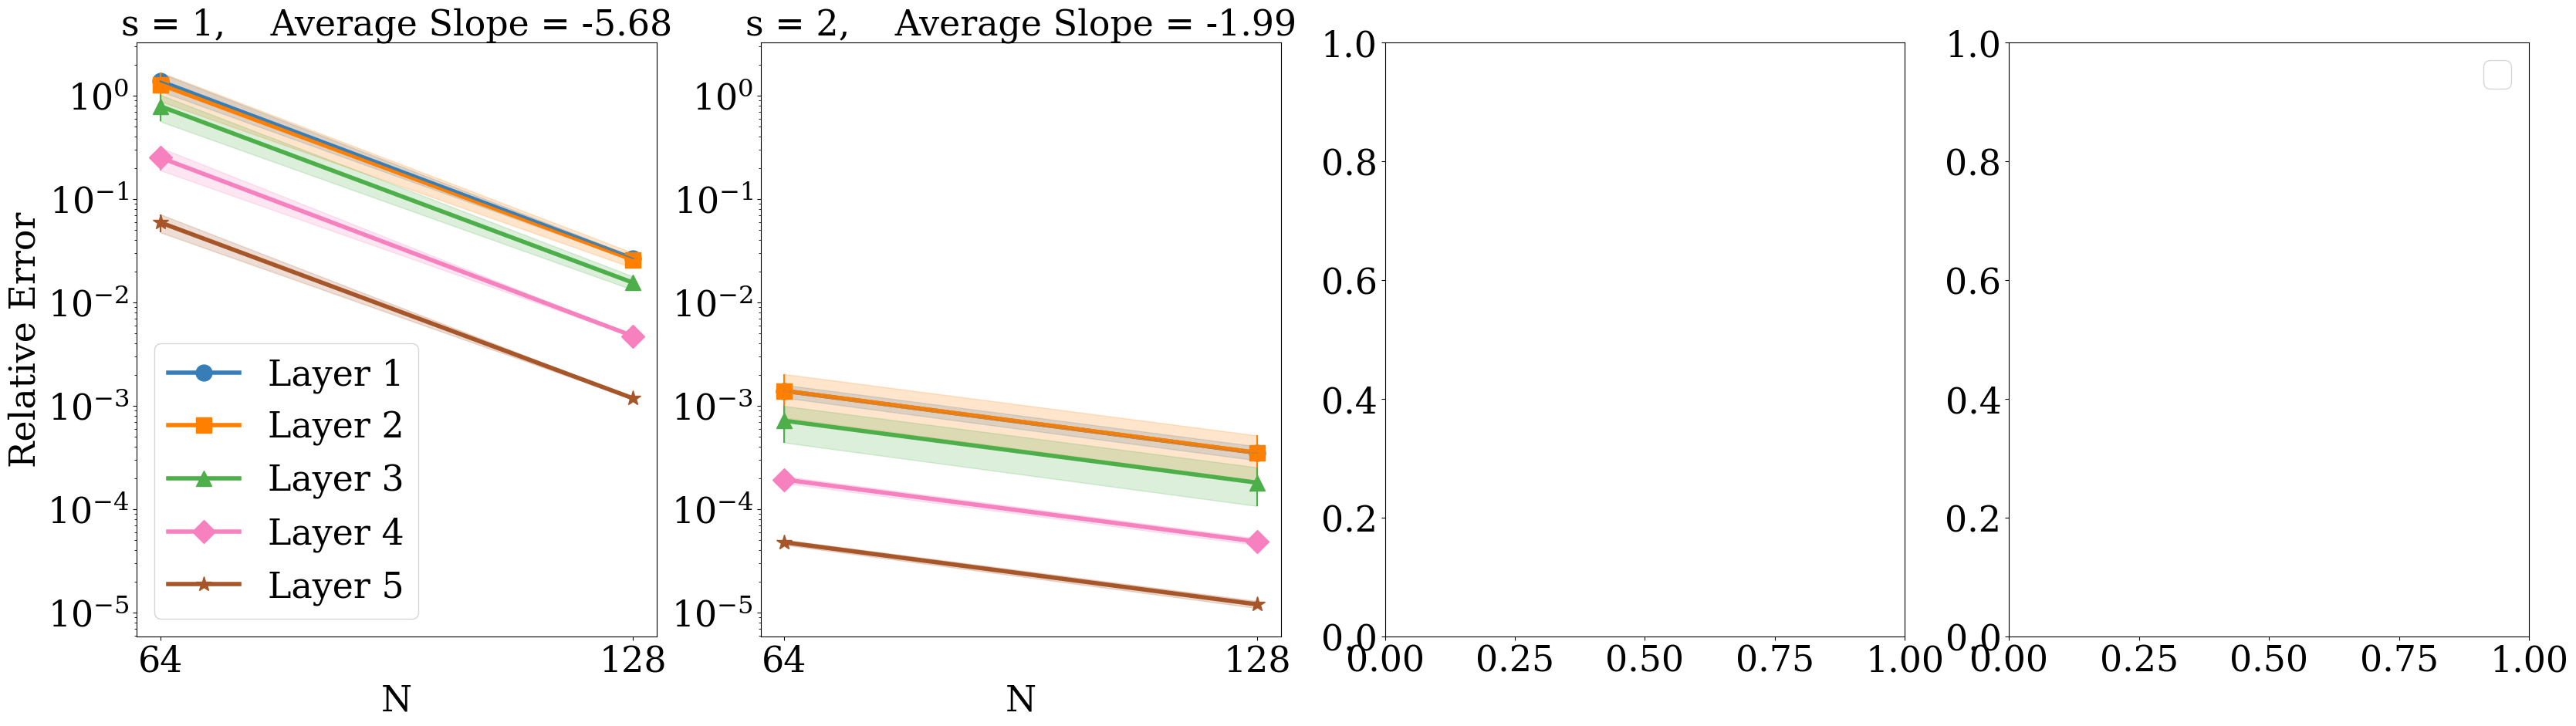

In [ ]:
plot_err_vs_N(all_err_s_norm,plot_sizes,'err_vs_N_default')